## Problem Statement

Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:
 

Historical data of demand for a product-center combination (Weeks: 1 to 145)
Product(Meal) features such as category, sub-category, current price and discount
Information for fulfillment center like center area, city information etc.

### Data Dictionary

Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable
 
Variable|	Definition
---| ---
id|	Unique ID
week|	Week No
center_id|	Unique ID for fulfillment center
meal_id|	Unique ID for Meal
checkout_price|	Final price including discount, taxes & delivery charges
base_price|	Base price of the meal
emailer_for_promotion|	Emailer sent for promotion of meal
homepage_featured|	Meal featured at homepage
num_orders|	(Target) Orders Count

fulfilment_center_info.csv: Contains information for each fulfilment center
 
Variable|	Definition
---| ---
center_id|	Unique ID for fulfillment center
city_code|	Unique code for city
region_code|	Unique code for region
center_type|	Anonymized center type
op_area|	Area of operation (in km^2)

meal_info.csv: Contains information for each meal being served
 
Variable|	Definition
---| ---
meal_id|	Unique ID for the meal
category|	Type of meal (beverages/snacks/soups….)
cuisine|	Meal cuisine (Indian/Italian/…)  

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from scipy import stats
from scipy.stats import norm, skew


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_QoiMO9B.csv')
center_info = pd.read_csv('fulfilment_center_info.csv')
meal_info = pd.read_csv('meal_info.csv')

In [4]:
train.shape

(456548, 9)

In [5]:
test.shape

(32573, 8)

In [6]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [7]:
center_info.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [8]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


Combine the train data with center info and meal info.

In [9]:
y = train['num_orders']
combine = pd.concat([train,test])
combine = combine.merge(center_info,on=['center_id'],how='left')
combine = combine.merge(meal_info,on=['meal_id'],how='left')

In [10]:
combine.shape

(489121, 15)

In [11]:
na_percent = combine.isnull().sum(axis=0)/combine.shape[0]
na_total = combine.isnull().sum()
unique_values = combine.apply(lambda x: x.nunique())

pd.concat([na_total,na_percent,unique_values], axis=1).rename(columns={0:'missing_total',1:'missing_percent',2:'unique_values'})

,missing_total,missing_percent,unique_values
base_price,0,0.000000,1931
center_id,0,0.000000,77
checkout_price,0,0.000000,1995
emailer_for_promotion,0,0.000000,2
homepage_featured,0,0.000000,2
id,0,0.000000,489121
meal_id,0,0.000000,51
num_orders,32573,0.066595,1250
week,0,0.000000,155
city_code,0,0.000000,51


### Feature Engineering

#### Create new variables: 

average number of orders for each center and meal combined category
average number of orders for each center
average number of orders for each type of meal

In [12]:
combine['mean_center_meal'] = combine.groupby(['center_id','meal_id'])['num_orders'].transform('mean')
combine['mean_center'] = combine.groupby(['center_id'])['num_orders'].transform('mean')
combine['mean_meal'] = combine.groupby(['meal_id'])['num_orders'].transform('mean')

transform week to day of the week and calculate related variables


In [13]:
combine['week_no'] = combine['week'].apply(lambda x: x%7)
combine['week_center'] = combine.groupby(['center_id','week_no'])['num_orders'].transform('mean')
combine['week_meal'] = combine.groupby(['meal_id','week_no'])['num_orders'].transform('mean')
combine['mean_week'] = combine.groupby(['week_no'])['num_orders'].transform('mean')

In [14]:
combine['discount'] = combine['checkout_price']/combine['base_price']

In [15]:
combine.head()

,base_price,center_id,checkout_price,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,week,city_code,...,category,cuisine,mean_center_meal,mean_center,mean_meal,week_no,week_center,week_meal,mean_week,discount
0,152.29,55,136.83,0,0,1379560,1885,177.0,1,647,...,Beverages,Thai,230.324138,163.475709,752.456365,1,160.357616,773.699875,257.13581,0.898483
1,135.83,55,136.83,0,0,1466964,1993,270.0,1,647,...,Beverages,Thai,246.972414,163.475709,598.853544,1,160.357616,625.334369,257.13581,1.007362
2,135.86,55,134.86,0,0,1346989,2539,189.0,1,647,...,Beverages,Thai,190.555556,163.475709,309.494594,1,160.357616,320.301514,257.13581,0.992639
3,437.53,55,339.50,0,0,1338232,2139,54.0,1,647,...,Beverages,Indian,21.792079,163.475709,42.813462,1,160.357616,44.336711,257.13581,0.775947
4,242.50,55,243.50,0,0,1448490,2631,40.0,1,647,...,Beverages,Indian,55.589147,163.475709,104.239051,1,160.357616,110.064559,257.13581,1.004124


In [16]:
combine['mean_center_meal'].fillna(0,inplace=True)

In [17]:
combine.isna().sum()

base_price                   0
center_id                    0
checkout_price               0
emailer_for_promotion        0
homepage_featured            0
id                           0
meal_id                      0
num_orders               32573
week                         0
city_code                    0
region_code                  0
center_type                  0
op_area                      0
category                     0
cuisine                      0
mean_center_meal             0
mean_center                  0
mean_meal                    0
week_no                      0
week_center                  0
week_meal                    0
mean_week                    0
discount                     0
dtype: int64

#### Label encoding categorical variable

In [18]:
cols = ['category','center_type','cuisine']

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(combine[c].values)) 
    combine[c] = lbl.transform(list(combine[c].values))

In [19]:
combine.drop(['id','num_orders'],axis=1,inplace=True)

### Log-transformation of the target variable


 mu = 261.87 and sigma = 395.92



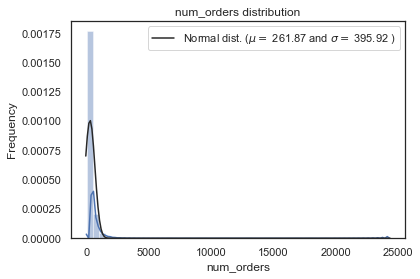

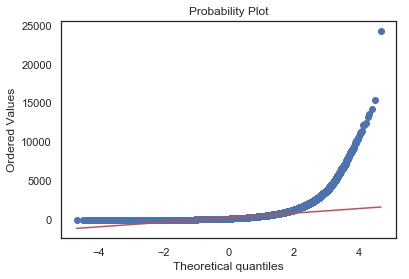

In [20]:
sns.distplot(y, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('num_orders distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()


 mu = 4.89 and sigma = 1.20



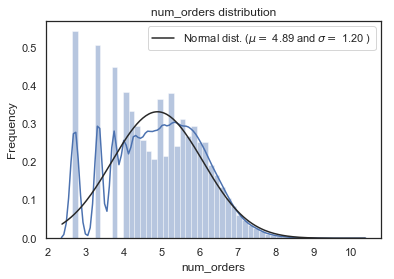

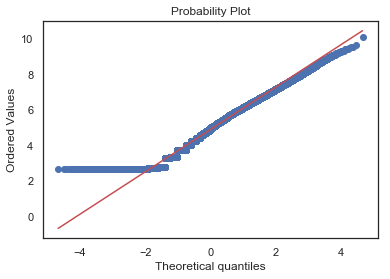

In [21]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y = np.log1p(y)

#Check the new distribution 
sns.distplot(y, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('num_orders distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

### Modeling

To simulate the real test data, we use the last 10 week as cross-validation set

### Base models

XGBoost: label encoding vs. one-hot-encoding

LightGBM

In [26]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m, X_train,y_train,X_valid,y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
    print(res)

In [23]:
model_xgb = xgb.XGBRegressor(max_depth=8,learning_rate=0.1,n_estimators=100,n_jobs=-1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [28]:
def lgb_modeling(combine,y,n):
    cat_cols = ('week_no','center_id','meal_id','city_code','region_code','category','center_type','cuisine')

    for c in cat_cols:
        combine[c] = combine[c].astype('category')
        
    train = combine.iloc[:n]
    test = combine.iloc[n:]
    
    val_idx = train.index[(train['week']>135) & (train['week']<146)].tolist()
    trn_idx = train.index[(train['week']<136)].tolist()
    
    train.drop(['week'],axis=1,inplace=True)
    test.drop(['week'],axis=1,inplace=True)
    
    X_train, y_train = train.iloc[trn_idx],y[trn_idx]
    X_valid, y_valid = train.iloc[val_idx],y[val_idx]
    
    model_lgb.fit(X_train.values, y_train)
    print_score(model_lgb,X_train,y_train,X_valid,y_valid)
    

In [35]:
def xgb_modeling(combine,y,n,encoding):
            
    if encoding=='one-hot':
        
        ONE_HOT_COLS = ['city_code','center_type', 'category', 'cuisine']

        for col in ONE_HOT_COLS:
            s = combine[col].unique()

    # Create a One Hot Dataframe with 1 row for each unique value
        one_hot_df = pd.get_dummies(s, prefix='%s_' % col)
        one_hot_df[col] = s

    
        pre_len = len(combine)

    # Merge the one hot columns
        combine = combine.merge(one_hot_df, on=[col], how="left")
        assert len(combine) == pre_len
        combine.drop(['center_id','meal_id','city_code','region_code','category','center_type','cuisine'],axis=1,inplace=True)
        
        train = combine.iloc[:n]
        test = combine.iloc[n:]
    
        val_idx = train.index[(train['week']>135) & (train['week']<146)].tolist()
        trn_idx = train.index[(train['week']<136)].tolist()
    
        train.drop(['week'],axis=1,inplace=True)
        test.drop(['week'],axis=1,inplace=True)
    
        X_train, y_train = train.iloc[trn_idx],y[trn_idx]
        X_valid, y_valid = train.iloc[val_idx],y[val_idx]
    
        model_xgb.fit(X_train.values, y_train)
        print_score(model_xgb,X_train.values,y_train,X_valid.values,y_valid)
    else:
        train = combine.iloc[:n]
        test = combine.iloc[n:]
    
        val_idx = train.index[(train['week']>135) & (train['week']<146)].tolist()
        trn_idx = train.index[(train['week']<136)].tolist()
    
        train.drop(['week'],axis=1,inplace=True)
        test.drop(['week'],axis=1,inplace=True)
    
        X_train, y_train = train.iloc[trn_idx],y[trn_idx]
        X_valid, y_valid = train.iloc[val_idx],y[val_idx]
    
        model_xgb.fit(X_train.values, y_train)
        print_score(model_xgb,X_train.values,y_train,X_valid.values,y_valid)

In [29]:
lgb_modeling(combine,y,len(train))

[0.5298613413270468, 0.5509636621001676, 0.8073280720720342, 0.7701184074582667]


In [34]:
xgb_modeling(combine,y,len(train),'label encoder')

[0.4678904336700623, 0.502142939845699, 0.8497611309674206, 0.809052926958811]


In [36]:
xgb_modeling(combine,y,len(train),'one-hot')

[0.47178631439957325, 0.506610191255511, 0.8472487927363181, 0.8056403411990635]


There is no over-fitting problem with the model. XGBoost with tranforming categorical variable into numeric (ordered) performed the best and therefore selected to be the final submitted model.